In [65]:
#НОМЕР ЭКСПЕРИМЕНТА, ЧТОБЫ НЕ ПУТАТЬСЯ С ДРУГИМИ ЭКСПЕРИМЕНТАМИ
NOMER_EXP = '22'

In [1]:
#Обучаем 2 сеттки. 
#делаем балансировку весов. второй класс дополнен сгенерированными 3000 элементами....

#КАНДИДАТ нА СДАЧУ РАБОТЫ

In [2]:
# Работа с массивами данных
import numpy as np 

# Работа с таблицами
import pandas as pd

# Отрисовка графиков
import matplotlib.pyplot as plt

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
import tensorflow as tf

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential,load_model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation 

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Кодирование тестовых меток
from sklearn.preprocessing import LabelEncoder

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline
import gc
import os

import pickle #это надо будет для сохранения токенайзеров

#from keras import backend as K
from sklearn.utils import class_weight

# несколько общих процедур

In [62]:
TRAIN_TEST_RATIO = 0.2

In [3]:
def seed_all(seed_value=0):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    np.random.seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)
    
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    

In [4]:
seed_all(1)

In [70]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model, 
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5),
                        class_weight = None,
                        title='',
                       nomer_modeli=''):

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(NOMER_EXP+'_'+nomer_modeli+'.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')

    
    
    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        callbacks=[earlyStopping, mcp_save,reduce_lr_loss],
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10),
              nomer_modeli=''):
    # Вычисление предсказания сети. Берем лучшую их сохраненных
    model8 = load_model(NOMER_EXP+'_'+nomer_modeli+'.mdl_wts.hdf5')
    
    
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)
    print(f'Нейросеть. Лучшая модель: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.2f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.2f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model, 
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=[], #CLASS_LIST было
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             class_weight = None,
                             cm_size=(10, 10),
                             nomer_modeli=''):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size,
                        class_weight  = class_weight,
                        title=title,
                       nomer_modeli=nomer_modeli)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test, 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size,
               nomer_modeli=nomer_modeli)

In [84]:
def get_recomended_VOCAB_SIZE(tokenizer, count):
    #получаем обученный токенайзер и минимальное количество слов, которое хотим оставить в словаре
    #возвращаем ничего, но печатаем строку с нужным размером словаря

    sl = list(tokenizer.word_counts.items())
    sl= sorted(sl,reverse=True,  key=lambda x: x[1])
    sl2 = [i  for i in sl if i[1]>count]
    print(f'Всего словарь: {len(sl)} для миним.повторов слов {count} установи размер словаря {len(sl2)}')

In [187]:
# Функция вывода сводки по распределению данных
def data_summary(df, class_labels):
    for cls in class_labels:
        print(f'Количество записей класса {cls}: {df[df.groups == cls].shape[0]}')    

In [204]:
def balance(df):
    #на входе - датафрейм
    #на выходе словарь для балансировки весов 
    w = dict()
    class_labels = df.groups.unique()
    
    w = {cls:df[df.groups == cls].shape[0] for cls in class_labels }
    
    m = max(w.values())
    w = {k:m/v for k,v in w.items()} #cчитаем веса
    keys = list(w.keys())
    #print('1',keys)
    keys.sort()
    #print(keys)
    w = {i: w[keys[i]] for i in range(len(class_labels))}
    return w 

In [ ]:
def get_memory_size():
    #смотрим, что там зависло в памяти, чтобы очистиь
    a = globals()
    mem = {i:round(sys.getsizeof(a[str(i)])/1024/1024, 2)  for i in a.keys()}
    mem = dict(sorted(mem.items(), key=lambda item: -item[1]))
    
    size = sum(mem.values())
    print('Объём в мегабайтах')
    print('ТОП 10', [(list(mem.keys())[i],   mem[list(mem.keys())[i]]) for i in range(10)] )
    print('Общий занятый объем: ', round(sum(mem.values()),2))

# Делаем первую сетку. Она будет отделять 10 класс от всего остального  

In [20]:
# Загрузка данных из файла в таблицу
df = pd.read_csv('train_dataset_train.csv')

In [51]:
# Вывод размерности таблицы
print('Пришел размер',df.shape)

Пришел размер (310300, 3)


In [22]:
# Вывод первых строк таблицы
df.head()    

,id,name,groups
0,1034,ШОК-ЦЕНА Пена д/душа/бритья КУППЕР 200 мл АКС,10
1,1035,Мин.вода Нагутская №26 0.5л,0
2,1036,Пельмени Домашние вес ПО Прямицино.,10
3,1037,ПЕЧЕНЬЕ ОВСЯНО-ГРЕЧНЕВОЕ ЭКО БОТ 4600508719365,10
4,1038,Спред растительно-жировой Масляничка 62% 170г ...,10


In [23]:
# Проверка, есть ли пропуски в данных
print(df.isnull().sum())

id        0
name      0
groups    0
dtype: int64


In [24]:
my_df = df[df.name.isnull()]
my_df.head(10)

,id,name,groups


In [25]:
df.fillna(value='ййй', inplace=True)

In [26]:
# Пример данных из таблицы
print(df.values[1001])

[2035 'Пряники "Шоколадные" пензенские' 10]


In [27]:
# Сводка по распределению данных
data_summary(df, df.groups.unique())

Количество записей класса 10: 502764
Количество записей класса 0: 21566
Количество записей класса 1: 17136
Количество записей класса 4: 27591
Количество записей класса 7: 12051
Количество записей класса 3: 21045
Количество записей класса 9: 42002
Количество записей класса 6: 10007
Количество записей класса 2: 3902


In [28]:
# Извелечение всех записей-текстов обращений и их меток классов
text_data = df.name.tolist()
class_data = df.groups.tolist()

In [29]:
text_data[:10]

['ШОК-ЦЕНА Пена д/душа/бритья КУППЕР 200 мл АКС',
 'Мин.вода Нагутская №26    0.5л',
 'Пельмени Домашние вес ПО Прямицино.',
 'ПЕЧЕНЬЕ ОВСЯНО-ГРЕЧНЕВОЕ ЭКО БОТ 4600508719365',
 'Спред растительно-жировой Масляничка 62% 170г С ЗМЖ',
 '4607040961429 ПЕЛЬМЕНИ ЗОЛОТО ДЭМК',
 '2: 3347584 МДБ Колб.ДОКТОР.в/с б/о в/у50',
 'Щипцы кухон. 23см пласт.+нерж. сталь ручка VETTA',
 "ИГР.ВИНО ПРОСЕККО НАЦИОНАЛЬ'19 Б 8032770293018",
 'Лапша удон, Курица с овощами, Соус терияки ']

# слегка отфильтруем. По 10 классу оставим только 150 000 примеров

In [30]:
# Назначение интервала допустимого количества текстов по классу
text_count_interval = [0, 155000]

# Фильтрация данных - отбрасываются все данные без категории
# и все классы объемом менее нижней границы разрешенного интервала
class_to_drop = ['нет данных']
for cls in df.groups.unique():
    if df[df.groups == cls].shape[0] < text_count_interval[0]:
        class_to_drop.append(cls)

print(f'Удаляются классы: {class_to_drop}')

del_mask = df.groups.isin(class_to_drop)
df = df[~del_mask]

# По всем оставшимся классам количество примеров ограничивается не более
# верхней границы разрешенного интервала
for cls in df.groups.unique():
    df = df.drop(df[df.groups == cls].index[text_count_interval[1]:])

Удаляются классы: ['нет данных']


In [31]:
data_summary(df, df.groups.unique())

Количество записей класса 10: 155000
Количество записей класса 0: 21566
Количество записей класса 1: 17136
Количество записей класса 4: 27591
Количество записей класса 7: 12051
Количество записей класса 3: 21045
Количество записей класса 9: 42002
Количество записей класса 6: 10007
Количество записей класса 2: 3902


In [52]:
print('Остался размер',df.shape)

Остался размер (310300, 3)


In [33]:
my_df = df[df.name.isnull()]
my_df.head(10)

,id,name,groups


In [34]:
df.fillna(value='ййй', inplace=True)

In [36]:

text_data = df.name.tolist()
class_data = df.groups.tolist()
class_data = [10 if x==10 else 0 for x in class_data ] #все классы, которые не относятся к 10, заменяем на 0. Итого у нас будет только 2 класса

In [37]:
class_data[:10]

[10, 0, 10, 10, 10, 10, 10, 10, 10, 0]

In [38]:
len(text_data)

310300

In [55]:
VOCAB_SIZE = 12909 #Сначала надо здесь указать макимально возможный, потом запустть следующие 2 ячейки и забрать оттуда размер словаря. ТАК БУДЕТ МЕНЬШЕ ПАМЯТИ

In [56]:

tokenizer = Tokenizer(num_words=VOCAB_SIZE,filters='0123456789!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',  split=' ', oov_token='неизвестное_слово', char_level=False)



tokenizer.fit_on_texts(text_data)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())
print(f'Размер словаря: {len(items)}')
del items

Размер словаря: 75451


In [85]:
get_recomended_VOCAB_SIZE(tokenizer,10)

Всего словарь: 34324 для миним.повторов слов 10 установи размер словаря 5356


In [58]:
# Кодирование меток классов индексами (числами)
encoder = LabelEncoder()
class_labels = encoder.fit_transform(class_data)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Список классов: {CLASS_LIST}')
print(f'Всего классов: {CLASS_COUNT}')
print(f'Форма выходных данных: {class_labels.shape}')
print(f'Пример числовых меток классов: {class_labels[:10]}')

Список классов: [ 0 10]
Всего классов: 2
Форма выходных данных: (310300,)
Пример числовых меток классов: [1 0 1 1 1 1 1 1 1 0]


# Создаем выборки для мешка слов

In [59]:
x_train_clip, y_train, x_test_clip, y_test,x_data,x_data_01,y_pred, model_text_bow_dense ='','','','','','','',''
x_train_01, y_train, x_test_01, y_test ='','','',''
gc.collect()

0

In [60]:
x_train_clip, y_train, x_test_clip, y_test,x_data,x_data_01,y_pred, model_text_bow_dense ='','','','','','','',''
x_train_01, y_train, x_test_01, y_test ='','','',''
gc.collect()

# Преобразование входных текстов в разреженную матрицу из векторов Bag of Words
x_data_01 = tokenizer.texts_to_matrix(text_data)
# Вывод формы и примера данных
print('для мешка')
print('Размер мешка', x_data_01.shape) 
#print(x_data_01[0, :20])

# Преобразование меток класса к векторам one hot encoding
y_data = utils.to_categorical(class_labels, CLASS_COUNT)
# Вывод формы и примера данных
print('Размер правды ', y_data.shape)
print(y_data[0])

#СОХРАНИМ ТОКЕНАЙЗЕР ДЛЯ МОДЕЛИ 1. Сохраняем токенайзер, чтобы им воспользоваться потом на предикте
with open('tokenizer_mod_1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

для мешка
Размер мешка (310300, 12909)
Размер правды  (310300, 2)
[0. 1.]


In [63]:
# Получение индексов разделения основного набора на обучающую и тестовую выборки
idx_train, idx_test = train_test_split(list(range(len(x_data_01))),
                                      stratify=y_data,
                                      test_size=TRAIN_TEST_RATIO,
                                      random_state = 11) #для повторяемости результата

# Разделение в соответствии с полученными индексами. Жрет память, не понял почему, присваивание нос-в-нос не жрет.
#x_train, x_test = x_data[idx_train], x_data[idx_test]
# x_train_01, x_test_01 = x_data_01[idx_train], x_data_01[idx_test]
# y_train, y_test = y_data[idx_train], y_data[idx_test]



x_train_01 =x_data_01[idx_train]
x_test_01 = x_data_01[idx_test]
y_train = y_data[idx_train]
y_test =  y_data[idx_test]



del x_data_01
del y_data
gc.collect()
# Проверка результата

print(x_train_01.shape, x_test_01.shape)
print(y_train.shape, y_test.shape)

(248240, 12909) (62060, 12909)
(248240, 2) (62060, 2)


# BagOfWords + Dense. Первая СЕТКА

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 150)               1936500   
_________________________________________________________________
batch_normalization_4 (Batch (None, 150)               600       
_________________________________________________________________
dense_13 (Dense)             (None, 200)               30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 402       
Total params: 1,967,702
Trainable params: 1,967,402
Non-trainable params: 300
_________________________________________________________________
Epoch 1/50
970/970 [==============================] - 11s 11ms/step - loss: 0.1521 - accuracy: 0.9430 - val_

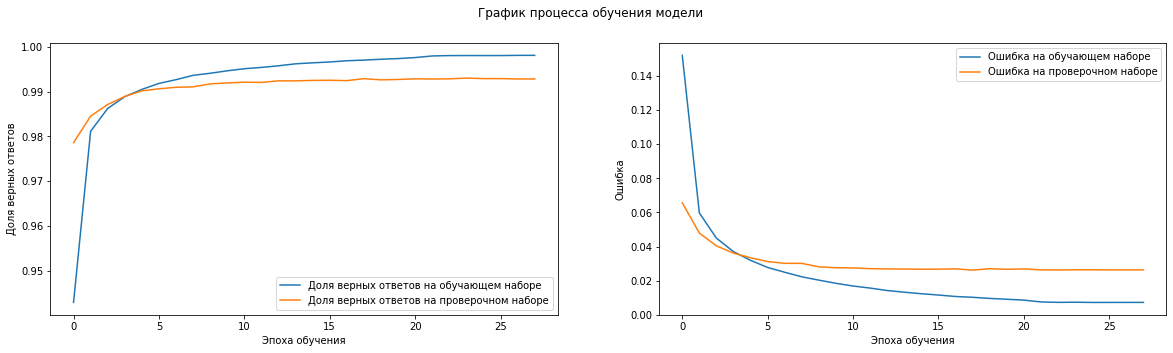

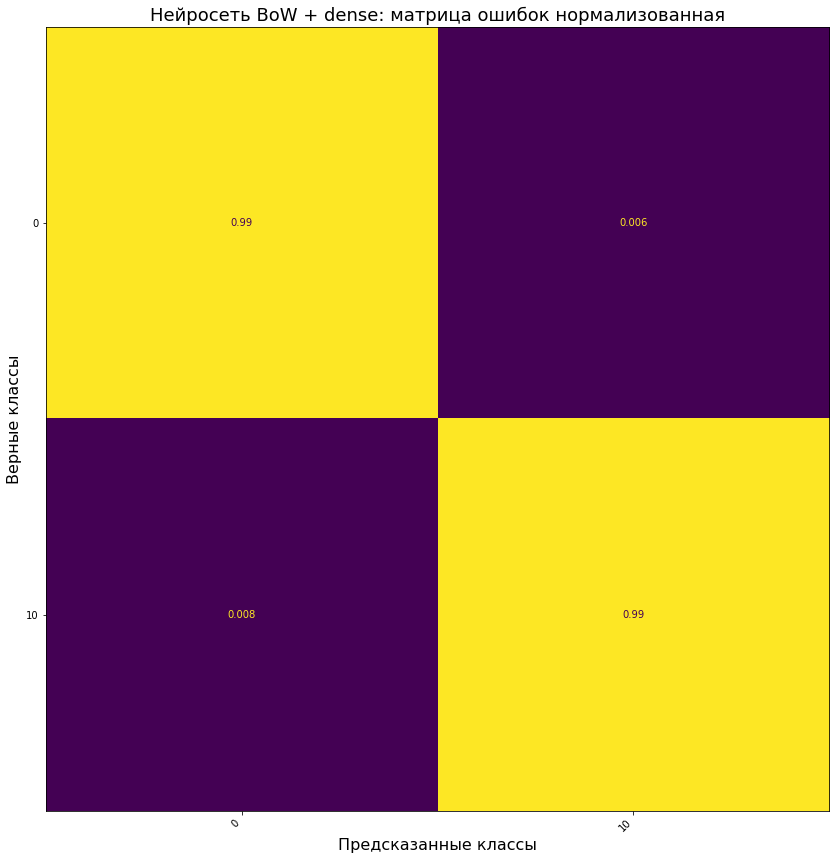

----------------------------------------------------------------------------------------------------
Нейросеть. Лучшая модель: BoW + dense
Класс: 0                    99.40% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 10                   99.20% сеть отнесла к классу 10                   - ВЕРНО :-)

Средняя точность распознавания: 99.30%


In [71]:
model_text_bow_dense,idx_train, idx_test ='','',''
gc.collect()

seed_all(1234)
model_text_bow_dense = Sequential()
model_text_bow_dense.add(Dense(150, input_dim=VOCAB_SIZE, activation="relu"))
model_text_bow_dense.add(BatchNormalization())


model_text_bow_dense.add(Dense(200, activation='relu'))
model_text_bow_dense.add(Dropout(0.5))

model_text_bow_dense.add(Dense(CLASS_COUNT, activation='softmax'))

#d_class_weights = {0:3.237373, 1:1}
d_class_weights=[]

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_dense,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         epochs=50,
                         batch_size=256,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                            class_weight = d_class_weights,
                          optimizer = 'SGD',  #100 эпох val_loss: 0.0307 - точность 99.05
                         title='BoW + dense',
                        nomer_modeli ='1')



# Теперь мы учим только на узких классах. Их всего 8

# ТОКЕНАЙЗЕР! ДЕЛАЕМ НОВЫЙ! У КАЖДОЙ СЕТКИ БУДЕТ СВОЙ. 

In [181]:
# Загрузка данных из файла в таблицу
df = pd.read_csv('train_dataset_train _mod3000.csv')

In [182]:
#удаляем 10 класс
df =df.loc[df['groups'] != 10]

In [183]:
df.head(20)

,id,name,groups
1,1035,Мин.вода Нагутская №26 0.5л,0
9,1043,"Лапша удон, Курица с овощами, Соус терияки",1
10,1044,"Макароны МАКФА Витки 231 3А, в/с 400гр., Челяб...",1
18,1052,"Вода 0,5 литр (Святой источник)",0
19,1053,"Напиток Любимый 1,93л цитрусовый Микс т/п",4
22,1056,"Напиток слабоалкогольный ""Медовуха"" темн. (Мед...",4
27,1061,"ЧАЙ ""МАЛИНА -ТИМЬЯН""",7
31,1065,"Молоко Мещерские Росы 3,2%",3
34,1068,Хлеб Бородинский фирменный 5,9
35,1069,6: 3172177 HEINZ Печенье с яблоком 16,6


In [188]:
data_summary(df, df.groups.unique())

Количество записей класса 0: 21566
Количество записей класса 1: 17136
Количество записей класса 4: 27591
Количество записей класса 7: 12051
Количество записей класса 3: 21045
Количество записей класса 9: 42002
Количество записей класса 6: 10007
Количество записей класса 2: 6902


In [189]:
print(df.shape)

(158300, 3)


In [190]:
#отбалансируем .... хотя может быть было бы не плохо еще и дубли отттуда грохнуть
text_count_interval = [0, 42002]

# Фильтрация данных - отбрасываются все данные без категории
# и все классы объемом менее нижней границы разрешенного интервала
class_to_drop = ['нет данных']
for cls in df.groups.unique():
    if df[df.groups == cls].shape[0] < text_count_interval[0]:
        class_to_drop.append(cls)

print(f'Удаляются классы: {class_to_drop}')

del_mask = df.groups.isin(class_to_drop)
df = df[~del_mask]

# По всем оставшимся классам количество примеров ограничивается не более
# верхней границы разрешенного интервала
for cls in df.groups.unique():
    df = df.drop(df[df.groups == cls].index[text_count_interval[1]:])

Удаляются классы: ['нет данных']


In [191]:
data_summary(df, df.groups.unique())

Количество записей класса 0: 21566
Количество записей класса 1: 17136
Количество записей класса 4: 27591
Количество записей класса 7: 12051
Количество записей класса 3: 21045
Количество записей класса 9: 42002
Количество записей класса 6: 10007
Количество записей класса 2: 6902


In [192]:
text_data = df.name.tolist()
class_data = df.groups.tolist()

In [193]:
VOCAB_SIZE = 18616

In [194]:

tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='0123456789!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)



# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_data)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())
print(f'Размер словаря: {len(items)}')
del items

Размер словаря: 34325


In [195]:
get_recomended_VOCAB_SIZE(tokenizer,1)

Всего словарь: 34324 для миним.повторов слов 1 установи размер словаря 18616


In [196]:
# Кодирование меток классов индексами (числами)
encoder = LabelEncoder()
class_labels = encoder.fit_transform(class_data)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Список классов: {CLASS_LIST}')
print(f'Всего классов: {CLASS_COUNT}')
print(f'Форма выходных данных: {class_labels.shape}')
print(f'Пример числовых меток классов: {class_labels[:10]}')

Список классов: [0 1 2 3 4 6 7 9]
Всего классов: 8
Форма выходных данных: (158300,)
Пример числовых меток классов: [0 1 1 0 4 4 6 3 7 5]


# Создаем выборки для мешка слов 

In [197]:
x_train_clip, y_train, x_test_clip, y_test,x_data,x_data_01,y_pred, model_text_bow_dense ='','','','','','','',''
x_train_01, y_train, x_test_01, y_test ='','','',''
x_data_01 = ''
gc.collect()

3140

In [198]:
len(text_data)

158300

In [199]:

# Преобразование входных текстов в разреженную матрицу из векторов Bag of Words
x_data_01 = tokenizer.texts_to_matrix(text_data)
# Вывод формы и примера данных
print('Размер мешка: ', x_data_01.shape)
print('Пример мешка: ', x_data_01[0, :20])

# Преобразование меток класса к векторам one hot encoding
y_data = utils.to_categorical(class_labels, CLASS_COUNT)
# Вывод формы и примера данных
print('Размер правды: ',y_data.shape )
print('Пример правды', y_data[0])

#СОХРАНИМ ТОКЕНАЙЗЕР ДЛЯ МОДЕЛИ 2
with open('tokenizer_mod_2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Размер мешка:  (158300, 18616)
Пример мешка:  [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размер правды:  (158300, 8)
Пример правды [1. 0. 0. 0. 0. 0. 0. 0.]


In [200]:
TRAIN_TEST_RATIO = 0.2
# Получение индексов разделения основного набора на обучающую и тестовую выборки
idx_train, idx_test = train_test_split(list(range(len(x_data_01))),
                                      stratify=y_data,
                                      test_size=TRAIN_TEST_RATIO,
                                      random_state = 11)

# Разделение в соответствии с полученными индексами
#x_train, x_test = x_data[idx_train], x_data[idx_test]

#x_train_01, x_test_01 = x_data_01[idx_train], x_data_01[idx_test]
#y_train, y_test = y_data[idx_train], y_data[idx_test]




x_train_01 =x_data_01[idx_train]
x_test_01 = x_data_01[idx_test]
y_train = y_data[idx_train]
y_test =  y_data[idx_test]

# Проверка результата

print(x_train_01.shape, x_test_01.shape)
print(y_train.shape, y_test.shape)

(126640, 18616) (31660, 18616)
(126640, 8) (31660, 8)


In [201]:
x_train_clip, x_test_clip, x_data,x_data_01,y_pred, model_text_bow_dense ='','','','','',''
x_data_01 = ''
gc.collect()

0

In [205]:
d_class_weights = balance(df)  #получаем веса для балансировки классов
print(d_class_weights)

{0: 1.9476027079662432, 1: 2.4510971055088704, 2: 6.085482468849609, 3: 1.9958184842005227, 4: 1.5223079989851764, 5: 4.19726191665834, 6: 3.4853539125383786, 7: 1.0}


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                595712    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_6 (Batch (None, 16)                64        
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
Total params: 596,568
Trainable params: 596,472
Non-trainable params: 96
_________________________________________________________________
Epoch 1/200
7915/7915 [==============================] - 53s 7ms/step - loss: 0.0810 - accuracy: 0.9830 - val_los

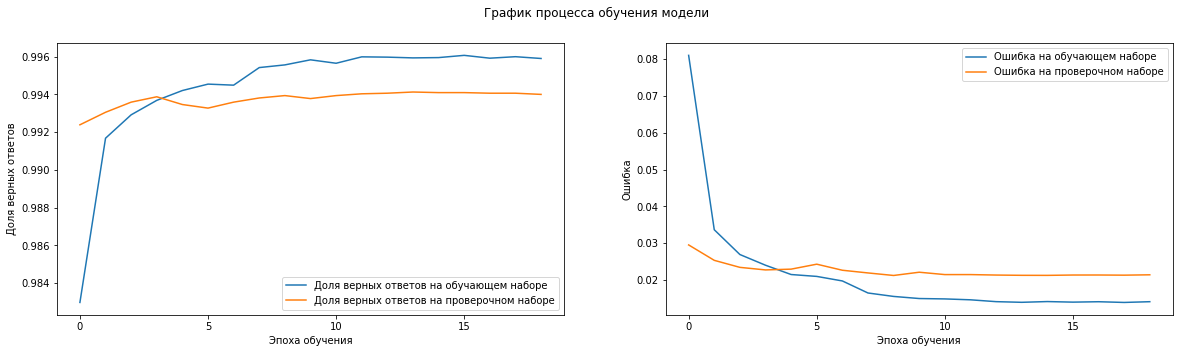

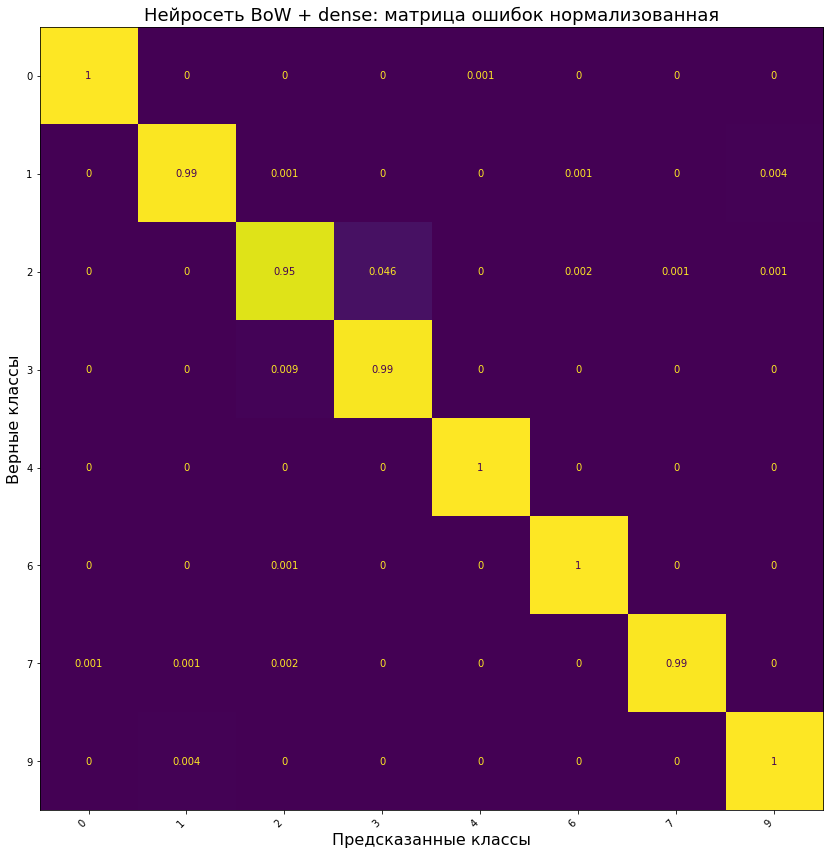

----------------------------------------------------------------------------------------------------
Нейросеть. Лучшая модель: BoW + dense
Класс: 0                    99.80% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                    99.40% сеть отнесла к классу 1                    - ВЕРНО :-)
Класс: 2                    95.10% сеть отнесла к классу 2                    - ВЕРНО :-)
Класс: 3                    99.00% сеть отнесла к классу 3                    - ВЕРНО :-)
Класс: 4                    99.90% сеть отнесла к классу 4                    - ВЕРНО :-)
Класс: 6                    99.90% сеть отнесла к классу 6                    - ВЕРНО :-)
Класс: 7                    99.50% сеть отнесла к классу 7                    - ВЕРНО :-)
Класс: 9                    99.60% сеть отнесла к классу 9                    - ВЕРНО :-)

Средняя точность распознавания: 99.02%


In [92]:
seed_all(1234)
gc.collect()
seed_all(1234)
# Последовательная модель
model_text_bow_dense = Sequential()
# Входной полносвязный слой
model_text_bow_dense.add(Dense(32, input_dim=VOCAB_SIZE, activation="relu"))
model_text_bow_dense.add(BatchNormalization())
# Слой регуляризации Dropout
#model_text_bow_dense.add(Dropout(0.2))
# Второй полносвязный слой
model_text_bow_dense.add(Dense(16, activation='relu'))
model_text_bow_dense.add(BatchNormalization())
#model_text_bow_dense.add(BatchNormalization())
# Слой регуляризации Dropout
#model_text_bow_dense.add(Dropout(0.1))
# Третий полносвязный слой
#model_text_bow_dense.add(Dense(35, activation='relu'))
# # Слой регуляризации Dropout
#model_text_bow_dense.add(Dropout(0.6))
# Выходной полносвязный слой
model_text_bow_dense.add(Dense(CLASS_COUNT, activation='softmax'))

#class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
# class_weight = class_weight.compute_class_weight(y_train)
# d_class_weights = dict(enumerate(class_weights))
# print(d_class_weights)
#[0 1 2 3 4 6 7 9]
#d_class_weights = {0:1, 1:1, 2:3.844, 3:1, 4:1, 6:1.499, 7:1.244, 9:1}
#d_class_weights = {0:1.9476, 1:2.451, 2:10.7642, 3:1.99582, 4:1.52231, 5:4.19726, 6:3.485354, 7:1}

#{0: 1.9476027079662432, 1: 2.4510971055088704, 2: 6.085482468849609, 3: 1.9958184842005227, 4: 1.5223079989851764, 5: 4.19726191665834, 6: 3.4853539125383786, 7: 1.0}


# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_dense,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         epochs=200,
                         batch_size=16,
                         cm_size=(16, 16),
                         optimizer = 'SGD',
                         class_labels=CLASS_LIST,
                         class_weight = d_class_weights,
                         title='BoW + dense',
                        nomer_modeli ='2')

# ФОРМИРУЕМ САБМИТ

# ДЕЛАЕМ ОБЩИЙ КОД ИЗ ДВУХ НЕЙРОНОК

In [93]:
#сначала определяем 10 класс и все остальное, потом все остальное делим на 8 классов 
#сразу формируем список в сабмит

In [94]:
x_train_clip, y_train, x_test_clip, y_test,x_data,x_data_01,y_pred ='','','','','','',''
gc.collect()

15501

In [95]:
# Загрузка данных из файла в таблицу
#df_test = pd.read_csv('test_dataset_test.csv')
df_test = pd.read_csv('test_dataset_test.csv')

In [96]:
df_test.fillna(value='ййй', inplace=True)
test_data = df_test.name.tolist()
test_id = df_test.id.tolist()

In [134]:
x_train_clip, y_train, x_test_clip, y_test,x_data,x_data_01,y_pred ='','','','','','',''
x_data_02, x_data_02 = '',''
model10, model8 = '',''
x_data_01 = '' 
gc.collect()




2148

# быстрая выгрузка. ускорено в 10 раз. 

In [138]:
%%time
gc.collect()

model10 = load_model(f'{NOMER_EXP}_1.mdl_wts.hdf5') #модель для анализа 10 класса и все осталььные

with open('tokenizer_mod_1.pickle', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

x_data_01 = tokenizer1.texts_to_matrix(test_data)


new_f = 'id,groups'
CLASS_LIST8 = list("01234679")
CLASS_LIST10 = [ '0', '10']
step = 10000

ind = []
strok = 0
for i in range(0, x_data_01.shape[0], step):
    gc.collect()
    
    print('Партия',i )
    
    #предиктим партию
    y_pred = model10.predict(x_data_01[i:i+step]) 
    
    #предикт переводим в список классов
    y_pred=list(map(lambda x: CLASS_LIST10[np.argmax(x)], y_pred)) #получили список классов по предикту
    
    
    for n in range(len(y_pred)):
        cls = y_pred[n]
        if cls != '10': #если унас класс не 10, то следует уточнить в другой модели, что же у нас за класс такой.
            ind.append(i + n) #добавляем нужный индекс
            continue
      
        #запишем в файл    
        id = test_id[i+n]
        st = f"{id},{cls}"
        new_f = new_f +'\n'+st
        strok +=1

#Теперь берем то, что не попало в 10 класс и надо его распознавать.  
print('\n\nТЕПЕРЬ Берем то, что не попало в 10')



del x_data_01,y_pred
del model10, tokenizer1
gc.collect()

model8 = load_model(f'{NOMER_EXP}_2.mdl_wts.hdf5') #модель для анализа всех остальных
with open('tokenizer_mod_2.pickle', 'rb') as handle:
    tokenizer2 = pickle.load(handle)
    

x_data_02 = tokenizer2.texts_to_matrix(test_data)
x_train_02 = x_data_02[ind] #фильтруем данные после работы певой сетки
test_id2 = [test_id[i] for i in ind] #jоставляем только id из нужных позиций

for i in range(0, x_train_02.shape[0], step):
   
    print('Партия',i )
    y_pred = model8.predict(x_train_02[i:i+step]) 
    #предикт переводим в список классов
    y_pred=list(map(lambda x: CLASS_LIST8[np.argmax(x)], y_pred)) #получили список классов
    
    for n in range(len(y_pred)):
        cls = y_pred[n]
        id = test_id2[i+n]
        st = f"{id},{cls}"
        new_f = new_f +'\n'+st
        strok +=1




test_out = NOMER_EXP+'_sample_solution.csv'  #сюда запишется резултат
if os.path.exists(test_out):
    os.remove(test_out)
    
with open(test_out, 'w', encoding = 'utf-8') as file:
    file.write(new_f)
print('готово', test_out) 
print('Записано строк ', strok)

del x_data_02, new_f
del model8, tokenizer2


gc.collect()

Партия 0
Партия 10000
Партия 20000
Партия 30000
Партия 40000
Партия 50000
Партия 60000
Партия 70000
Партия 80000
Партия 90000
Партия 100000
Партия 110000
Партия 120000
Партия 130000
Партия 140000
Партия 150000
Партия 160000
Партия 170000
Партия 180000
Партия 190000
Партия 200000
Партия 210000
Партия 220000
Партия 230000
Партия 240000
Партия 250000
Партия 260000
Партия 270000
Партия 280000


Берем то, что не попало в 10
Партия 0
Партия 10000
Партия 20000
Партия 30000
Партия 40000
Партия 50000
Партия 60000
готово 22_sample_solution.csv
Записано строк  282227
CPU times: total: 1min 55s
Wall time: 1min 47s


2748